In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [4]:
Basemodels = pd.read_csv('C:/Users/loren/Desktop/dap/dap/Scraped_20-11-2023/base model iphones 4 - 15.csv')
MidTierModels = pd.read_csv('C:/Users/loren/Desktop/dap/dap/Scraped_20-11-2023/mid tier & special edition iphones 4 - 15.csv')
ExpensiveModels = pd.read_csv('C:/Users/loren/Desktop/dap/dap/Scraped_20-11-2023/most expensive model iphones 4 - 15.csv')

In [6]:
rawdata = pd.concat([Basemodels, MidTierModels, ExpensiveModels], ignore_index=True)
print(rawdata['condition'].unique())

['Gebraucht | Privat' 'Gebraucht | Gewerblich' 'Brandneu | Gewerblich'
 'Brandneu | Privat' 'Nur Ersatzteile | Privat'
 '➡️ Händler / Garantie / inkl. Ladezubehör ♦️ TOP ⬅️'
 'Nur Ersatzteile | Gewerblich' 'Neu (Sonstige) | Privat'
 'Hervorragend - Refurbished | Gewerblich'
 'Gut - Refurbished | Gewerblich'
 '🔥AKTION AKTION🔥 -30 Tage Testen - AKTION🔥 AKTION🔥'
 'Neu (Sonstige) | Gewerblich' 'Sehr gut - Refurbished | Gewerblich'
 'Differenzbesteuerung gemäß §25A UStG'
 '🔥EBAY KÄUFERSCHUTZ 🔥 FACHHANDEL 🔥 VERSAND AUS NRW'
 '100% Batteriekapazität - Nicht am falschen Ende sparen!'
 '*** Neuwertig , schneller Versand, DE Händler ***'
 'DE Händler - Blitzversand - 1 Monat Widerruf - TOP!'
 'Händler / Lagerware / DHL'
 'DE Händler / Rechnung / zum MwSt-Ausweis s.u. (*)'
 'Artikel unterliegt Differenzbesteuerung nach §25a UstG'
 'DE Händler - Blitzversand - 1 Monat Widerruf!'
 '✳️BONUSSET -  24 Monate Garantie ✳️'
 '🔥Panzerglas ✅ Hülle ✅ Ladekabel ✅ Netzteil ✅ OVP ✅ 🔥'
 '🔥VIELE IPHONE MODELLE🔥B

In [17]:
rawdata['Price'] = rawdata['Price'].replace('[\\$,]', '', regex=True)
rawdata['Price'] = rawdata['Price'].apply(lambda x: np.mean([float(i) for i in x.split(' to ')] if ' to ' in x else float(x) if x else 0))

In [18]:
print(rawdata['Model'].value_counts())

Model
iPhone 14 Pro Max    777
iPhone XR            472
iPhone 12 Pro Max    258
iPhone 11 Pro Max    181
iPhone 13 Pro Max    151
Name: count, dtype: int64


In [19]:
rawdata['Storage'] = rawdata['Title'].str.extract(r'(\d+GB)', expand=False)
rawdata = rawdata.dropna(subset=['Storage'])
rawdata['Storage'] = rawdata['Storage'].replace('126GB', '128GB')
rawdata['Storage'] = rawdata['Storage'].str.rstrip('GB').astype(int)

In [20]:
print(rawdata.groupby(['Model', 'Storage'])['Price'].mean())

Model              Storage
iPhone 11 Pro Max  64          410.640654
                   256         427.392143
                   512         508.100625
iPhone 12 Pro Max  128         533.751856
                   256         513.125714
                   512         661.270800
iPhone 13 Pro Max  128         605.947778
                   256         738.140217
                   512         730.290435
iPhone 14 Pro Max  128         893.857791
                   256         941.617907
                   512        1135.416857
                   1024        900.000000
iPhone XR          64          209.097823
                   128         378.877778
                   256         423.527853
Name: Price, dtype: float64


In [21]:
release_dates = {
    'iPhone XR': '2018-10-26',
    'iPhone 11 Pro Max': '2019-09-20',
    'iPhone 12 Pro Max': '2020-11-13',
    'iPhone 13 Pro Max': '2021-09-24',
    'iPhone 14 Pro Max': '2022-09-16'
}
rawdata['ReleaseDate'] = rawdata['Model'].map(release_dates)
rawdata['ReleaseDate'] = pd.to_datetime(rawdata['ReleaseDate'])

In [22]:
release_prices= {
    'iPhone XR': {64: 749, 128: 799, 256: 899},
    'iPhone 11 Pro Max': {64: 1099, 256: 1249, 512: 1449},
    'iPhone 12 Pro Max': {128: 1099, 256: 1199, 512: 1399},
    'iPhone 13 Pro Max': {128: 1099, 256: 1199, 512: 1399, 1024: 1599},
    'iPhone 14 Pro Max': {128: 1099, 256: 1199, 512: 1399, 1024: 1599}
}
rawdata['ReleasePrice'] = rawdata.apply(lambda row: release_prices[row['Model']][row['Storage']], axis=1)

In [23]:
rawdata['DiscountPerYear'] = (rawdata['ReleasePrice'] - rawdata['Price']) / ((2023 - rawdata['ReleaseDate'].dt.year) + 1)

In [24]:
print(rawdata.groupby(['Model', 'Storage'])['DiscountPerYear'].mean())

Model              Storage
iPhone 11 Pro Max  64         137.671869
                   256        164.321571
                   512        188.179875
iPhone 12 Pro Max  128        141.312036
                   256        171.468571
                   512        184.432300
iPhone 13 Pro Max  128        164.350741
                   256        153.619928
                   512        222.903188
iPhone 14 Pro Max  128        102.571104
                   256        128.691047
                   512        131.791571
                   1024       349.500000
iPhone XR          64          89.983696
                   128         70.020370
                   256         79.245358
Name: DiscountPerYear, dtype: float64


In [25]:
price_correlation = rawdata[['Storage', 'ReleasePrice']].corr()
print(price_correlation)

               Storage  ReleasePrice
Storage       1.000000      0.736089
ReleasePrice  0.736089      1.000000


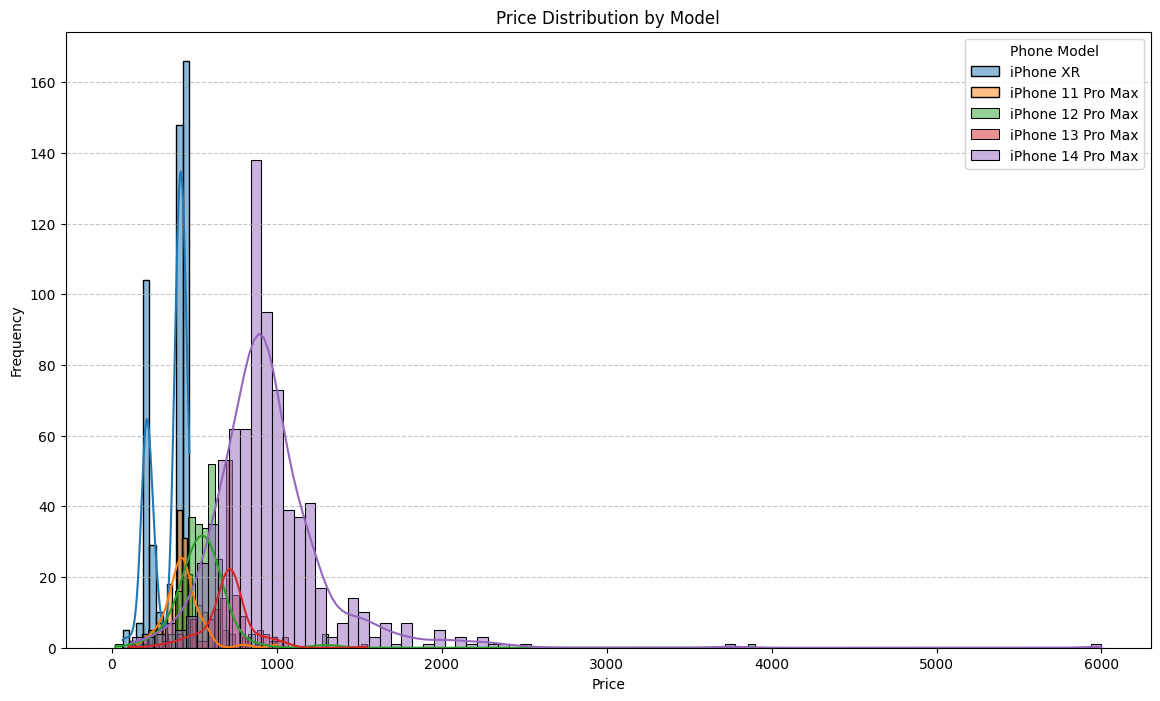

In [26]:
plt.figure(figsize=(14, 8))

unique_models = rawdata['Model'].unique()

for model in unique_models:
    sns.histplot(data=rawdata[rawdata['Model'] == model], x='Price', label=model, edgecolor='black', kde=True)

plt.title('Price Distribution by Model')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Phone Model', bbox_to_anchor=(1, 1))

plt.show()
